## imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage, compute_usage, assign_onsets
%matplotlib inline
import datetime

In [2]:
def mouse_map(string):
    '''returns mouse identity'''
    if 'nt' in string:
        m='_01'
    elif 'RL' in string:
        m='_04'
    elif 'R' in string:
        m='_02'
    elif 'L' in string:
        m='_03'
    if 'ong4' in string:
        return '04'+m
    if 'ong3' in string:
        return '03'+m
    if 'ong2' in string:
        return '02'+m
    if 'ong1' in string:
        return '01'+m
    if 'ong5' in string:
        return '05'+m
    return string[:5]

In [3]:
## for males

In [4]:
## upload data frame females
data_folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_03')
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/longtogeny_females_syllable_df.parquet')
df = pd.read_parquet(path)

## get syllable maps from male ontogeny
df_temp = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_males_syllable_df.parquet')
df_temp,usage_map = relabel_by_usage(df_temp, return_map=True)

df = assign_onsets(df)
df['relabeled_syllables'] = df['syllables'].map(usage_map)
#df = relabel_by_usage(df, return_map=False)

In [5]:
## add extra females to the dataframe
extra_females=pd.read_parquet(data_folder / "longtogeny_extra_females.parquet", engine='pyarrow') 
df=pd.concat([df,extra_females])

In [6]:
# calculate age for males
first= pd.Timestamp(year=2021, month=7, day=15)
age = (df.date-first).dt.days+21
df.age=age

## manual curations

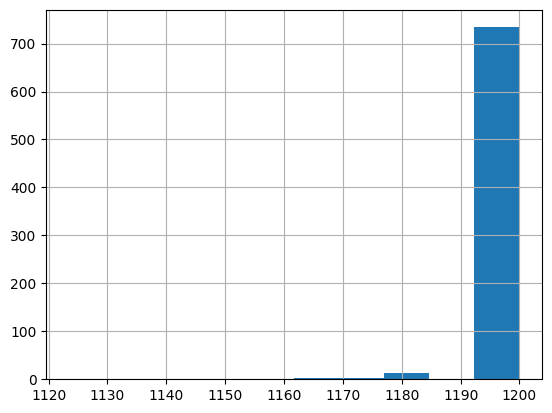

In [7]:
# clean up the data by removing short sessions
t = 600
session_length = df.groupby("uuid", sort=False)['timestamps'].max()
remove_uuids = session_length[session_length < t].index
session_length.hist()
df = df[~df['uuid'].isin(remove_uuids)]

<Axes: >

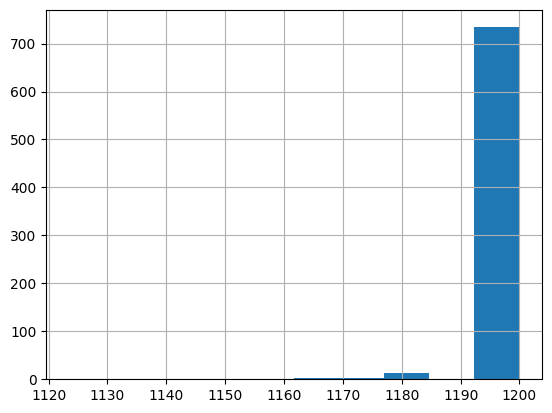

In [8]:
session_length = df.groupby("uuid", sort=False)['timestamps'].max()
remove_uuids = session_length[session_length < t].index
session_length.hist()

## get mouse names

In [9]:
# calculate mouse identity
df['mouse'] = df['subject_name'].map(mouse_map)

In [10]:
# calculate usage
usage_df = df.query('onsets').groupby(['age','uuid','mouse','subject_name','date'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()

In [11]:
## remove sessions were a syllable occours more than x% of time
thresh=0.15
syll_usage = usage_df.groupby("uuid", sort=False)['usage'].max()
remove_uuids=syll_usage[syll_usage>thresh].to_frame().reset_index()['uuid']
usage_df = usage_df[~usage_df['uuid'].isin(remove_uuids)]

In [12]:
# find ages where less than 8 data points exists and filter them out (not sure we want that)
temp = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age','uuid','subject_name','date']).fillna(0).reset_index()
counter = Counter(temp['age'])
thresh=8
remove_sessions = ([k for k, v in counter.items() if v < thresh])
usage_df = usage_df[~usage_df['age'].isin(remove_sessions)]

In [13]:
# define cage
usage_df['cage'] = usage_df.mouse.str[:2]

# some tests

In [14]:
# figure out if male and female data mixed by checking if for similar age we have a different session number
# calculate usage
temp = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age','uuid','subject_name','date']).fillna(0).reset_index()

ages = temp.age.unique()
for age in ages:
    curr = temp[temp.age==age]
    sessions = curr.subject_name.str[-3:] #get session number
    if len(sessions.unique())>1: #if the same age has different session numbers
        curr_print = curr[['subject_name','age','date']]
        print(curr_print)
        print(len(curr_print))

relabeled_syllables subject_name  age                date
119                    01_02_011   45 2021-08-08 13:34:02
120                    01_01_010   45 2021-08-08 13:32:01
121                    03_03_011   45 2021-08-08 14:47:33
122                    02_04_011   45 2021-08-08 14:20:44
123                    03_01_010   45 2021-08-08 14:47:46
124                    03_04_011   45 2021-08-08 14:47:28
125                    02_01_010   45 2021-08-08 14:21:09
126                    01_03_011   45 2021-08-08 13:33:11
127                    05_04_011   45 2021-08-08 15:40:51
128                    05_01_010   45 2021-08-08 15:40:45
129                    05_03_011   45 2021-08-08 15:40:58
130                    03_02_011   45 2021-08-08 14:47:40
131                    04_03_011   45 2021-08-08 15:14:19
132                    04_04_011   45 2021-08-08 15:13:04
133                    01_04_011   45 2021-08-08 13:32:23
134                    04_01_010   45 2021-08-08 15:13:20
135           

In [15]:
#check number of sessions per age
temp = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age','uuid','mouse','subject_name','date']).fillna(0).reset_index()
counter = Counter(temp['mouse'])
counter

Counter({'05_01': 44,
         '03_01': 43,
         '01_04': 43,
         '01_01': 42,
         '02_01': 42,
         '03_02': 42,
         '04_01': 41,
         '03_04': 39,
         '05_04': 39,
         '02_02': 39,
         '02_04': 38,
         '04_04': 38,
         '04_02': 37,
         '01_02': 37,
         '05_02': 36,
         '03_03': 30,
         '04_03': 29,
         '01_03': 28,
         '05_03': 25,
         '02_03': 24})

In [28]:
## get only the 16 mice which cages have the most sessions
#check number of sessions per cage
temp = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age','uuid','mouse','subject_name','date','cage']).fillna(0).reset_index()
print(Counter(temp['cage']))
cages=['03','01','04','05']
usage_df = usage_df[usage_df['cage'].isin(cages)]

Counter({'03': 154, '01': 150, '04': 145, '05': 144, '02': 143})


## save dataframe

In [29]:
usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'mouse','cage','uuid','subject_name']).fillna(0)
usage_mtx.to_parquet(data_folder / "longtogeny_females_clean.parquet", engine='pyarrow') 